# Data Analysis - Exercise 4
This lecture is about the time series forecasting utilizing deep learning. We will discuss the natural gas consumption forecasting topic using provided dataset as in the previous lecture.

Raw dataset is available at [vsb.ai](https://vsb.ai/natural-gas-forecasting), but we will use already pre-processed version of it. You can download the simplified version from our [Github](https://github.com/rasvob/2020-2021-DA4).

[Open in Google colab](https://colab.research.google.com/github/rasvob/2020-2021-DA4/blob/master/04_Forecasting_ANN.ipynb)

[Download from Github](https://github.com/rasvob/2020-2021-DA4/blob/master/04_Forecasting_ANN.ipynb)

## We start with importing commonly used libraries. 
- We will use maily Plotly again (you can see [this link](https://plotly.com/python/plotly-express/) for more information) for our visualizations.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
# from plotly.offline import init_notebook_mode
# init_notebook_mode(connected=False)
pd.set_option('display.max_colwidth', 100)
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
import datetime

We need to install the rstl dependency from pip for the time series decomposition.

In [2]:
!pip install rstl
import rstl

In [3]:
import tensorflow.compat.v2 as tf #use tensorflow v2 as a main 
import tensorflow.keras as keras # required for high level applications
tf.version.VERSION

'2.8.0'

In [4]:
!pip install tqdm
from tqdm.notebook import trange, tqdm
tqdm.pandas()

We have prepared common metrics for model evaluation beforehand. We will use these functions later.

In [5]:
"""
Computes MAPE
"""
def mean_absolute_percentage_error(y_true: np.array, y_pred: np.array) -> float:
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

"""
Computes SMAPE
"""
def symetric_mean_absolute_percentage_error(y_true: np.array, y_pred: np.array) -> float:
    return np.mean(np.abs((y_pred - y_true) / ((np.abs(y_true) + np.abs(y_pred))/2.0))) * 100

"""
Computes MAE, MSE, MAPE, SMAPE, R2
"""
def compute_metrics(df: pd.DataFrame) -> pd.DataFrame:
    y_true, y_pred = df['y_true'].values, df['y_pred'].values
    return compute_metrics_raw(y_true, y_pred)

def compute_metrics_raw(y_true: pd.Series, y_pred: pd.Series) -> pd.DataFrame:
    mae, mse, mape, smape, r2 = mean_absolute_error(y_true=y_true, y_pred=y_pred), mean_squared_error(y_true=y_true, y_pred=y_pred), mean_absolute_percentage_error(y_true=y_true, y_pred=y_pred), symetric_mean_absolute_percentage_error(y_true=y_true, y_pred=y_pred), r2_score(y_true=y_true, y_pred=y_pred)
    return pd.DataFrame.from_records([{'MAE': mae, 'MSE': mse, 'MAPE': mape, 'SMAPE': smape, 'R2': r2}], index=[0])

In [6]:
def show_history(history):
    plt.figure()
    for key in history.history.keys():
        plt.plot(history.epoch, history.history[key], label=key)
    plt.legend()
    plt.tight_layout()

# There is nothing new here yet :)
## The start of the lecture is exactly the same as in the previous one.

In [7]:
df = pd.read_csv('https://raw.githubusercontent.com/rasvob/2020-2021-DA4/master/datasets/ppnet_metar_v8_MAD.csv', sep=';', index_col=0)

### We will drop year 2019 for now and use only years 2013 to 2018

In [8]:
df = df[df.Year < 2019].copy()

In [9]:
df.loc[:, 'TestSet'] = 0
df.loc[df.Year == 2018, 'TestSet'] = 1

Dataset covers six whole years from January 1, 2013 to December 31, 2018. All data features are available at an hourly frequency. The whole dataset is composed of 52,584 data points. These data points were assembled from three main components.

The first component was created from consumption data. Prague is the capital city of the Czech Republic and its distribution network consisted of 422,926 customers in 2018. Total consumption was 3.82 billion m3. Residential sector included 381,914 households (33.3% of consumption). Industrial sector consisted from 177 big (24.8% of consumption), 39,175 medium (18.9% of consumption) and 1,652 small customers (21.9% of consumption). Missing remainder to 100% were operational losses that occurred during distribution, e.g., pipeline leak. The heating season in the Czech Republic is from September 1 to May 31. Usually, it is required for the heating season to begin that the temperature drops below +13 °C for two consecutive days, and no warming is forecasted for the following days. The heating season usually represents about 70% - 75% of the whole year's consumption.

The second component includes weather variables. We have used data from the Prague LKPR airport weather station. Airports are required to periodically issue METAR (aerodrome routine meteorological report) information. Those reports are archived and preserved for a long time.

The third component representing economic features are natural gas price data. We have obtained price data from the Czech energy regulation office and included them in the dataset.

In [10]:
df.head()

Year  Month  Day  Hour  Day_of_week  Before_holiday  \
Datetime                                                                   
2013-01-01 00:00:00  2013      1    1     0            2               1   
2013-01-01 01:00:00  2013      1    1     1            2               1   
2013-01-01 02:00:00  2013      1    1     2            2               1   
2013-01-01 03:00:00  2013      1    1     3            2               1   
2013-01-01 04:00:00  2013      1    1     4            2               1   

                     Holiday  Consumption  Temperature  Pressure  ...  \
Datetime                                                          ...   
2013-01-01 00:00:00        0     146584.0          0.0     733.0  ...   
2013-01-01 01:00:00        0     149524.0         -1.0     732.2  ...   
2013-01-01 02:00:00        0     151388.0          0.0     731.6  ...   
2013-01-01 03:00:00        0     152436.0         -1.0     731.5  ...   
2013-01-01 04:00:00        0     160176.0          0.0     731.1  ...   

                              Datetime.1        Clouds_low_text Clouds_low_m  \
Datetime                                                                       
2013-01-01 00:00:00  2013-01-01 00:00:00  no significant clouds          0.0   
2013-01-01 01:00:00  2013-01-01 01:00:00  no significant clouds          0.0   
2013-01-01 02:00:00  2013-01-01 02:00:00  no significant clouds          0.0   
2013-01-01 03:00:00  2013-01-01 03:00:00  no significant clouds          0.0   
2013-01-01 04:00:00  2013-01-01 04:00:00  no significant clouds          0.0   

                        Clouds_medium_text Clouds_medium_m  \
Datetime                                                     
2013-01-01 00:00:00  no significant clouds               0   
2013-01-01 01:00:00  no significant clouds               0   
2013-01-01 02:00:00  no significant clouds               0   
2013-01-01 03:00:00  no significant clouds               0   
2013-01-01 04:00:00  no significant clouds               0   

                          Clouds_high_text  Clouds_high_m  IsMissing  \
Datetime                                                               
2013-01-01 00:00:00  no significant clouds              0          0   
2013-01-01 01:00:00  no significant clouds              0          0   
2013-01-01 02:00:00  no significant clouds              0          0   
2013-01-01 03:00:00  no significant clouds              0          0   
2013-01-01 04:00:00  no significant clouds              0          0   

                    Cena_bfill TestSet  
Datetime                                
2013-01-01 00:00:00      26.57       0  
2013-01-01 01:00:00      26.57       0  
2013-01-01 02:00:00      26.57       0  
2013-01-01 03:00:00      26.57       0  
2013-01-01 04:00:00      26.57       0  

[5 rows x 28 columns]

### We have multiple features in the dataset. Consumption is the forecasted endogenous variable, other features are treated as exogenous.

In [11]:
df.columns

Index(['Year', 'Month', 'Day', 'Hour', 'Day_of_week', 'Before_holiday',
       'Holiday', 'Consumption', 'Temperature', 'Pressure', 'Pressure2',
       'Humidity', 'Wind_direction', 'Wind_speed', 'Phenomena',
       'Recent_phenomena', 'Visibility', 'Dewpoint', 'Datetime.1',
       'Clouds_low_text', 'Clouds_low_m', 'Clouds_medium_text',
       'Clouds_medium_m', 'Clouds_high_text', 'Clouds_high_m', 'IsMissing',
       'Cena_bfill', 'TestSet'],
      dtype='object')

We have circa 52k datapoints which should be sufficient even for very complex models.

In [12]:
df.shape

(52584, 28)

## It's not out of the question to look at the data one more time, it has been before a whole week after all...

In [13]:
px.line(y=df['Consumption'], x=df.index, color=df.Year)

In [14]:
df.index = pd.DatetimeIndex(df.index)

# We will start with the simplest task at hand - next hour consumption forecasting. 

## You will most commonly deal with RNN (various forms - LSTM, GRU and other modifications) or CNN in the time series data domain nowadays.
- There are of course use cases where classical MLP with fixed window is better, although it's usually in the univariate time series covering rather short time periods cases. You need to consider in these situations if you really need neural net or simple AR(p) model is enough.

## The problem framing is basically the same as in the ML approach we utilized in the last lecture. We need to transform the time series forecasting into a supervised learning task.
- We will use fixed-size time window for the feature engineering again.
- We will start with data of the last 24 hours combined with chosen time-related features as well as some dummy ones.

# Our first model will be univariate one - we will use only consumption data for simplicity.
- We will dive into more details lately - we will just train the baseline model now.

In [15]:
X, y = pd.DataFrame(), df.Consumption.copy()
for x in trange(24, 1, -1):
    X.loc[:, f'Consumption_lag_{x}'] = df.Consumption.shift(x)
    
X_train, X_test, y_train, y_test = X[df.TestSet == 0], X[df.TestSet == 1], y[df.TestSet == 0], y[df.TestSet == 1]

  0%|          | 0/23 [00:00<?, ?it/s]

In [16]:
X_train_selected_features_nona = X_train.drop(['Residual_diff_from_midnight', 'Year', 'Month', 'Day', 'Hour', 'Day_of_week','Temperature', 'Pressure', 'Pressure2', 'Humidity', 'Wind_direction', 'Wind_speed', 'Phenomena', 'Recent_phenomena', 'Visibility', 'Dewpoint', 'Datetime.1', 'Clouds_low_text', 'Clouds_low_m', 'Clouds_medium_text', 'Clouds_medium_m', 'Clouds_high_text', 'Clouds_high_m', 'Residual', 'ResetSignal', 'IsMissing', 'Cena_bfill', 'TestSet'], axis=1, errors='ignore').dropna()
X_test_selected_features_nona = X_test.drop(['Residual_diff_from_midnight', 'Year', 'Month', 'Day', 'Hour', 'Day_of_week','Temperature', 'Pressure', 'Pressure2', 'Humidity', 'Wind_direction', 'Wind_speed', 'Phenomena', 'Recent_phenomena', 'Visibility', 'Dewpoint', 'Datetime.1', 'Clouds_low_text', 'Clouds_low_m', 'Clouds_medium_text', 'Clouds_medium_m', 'Clouds_high_text', 'Clouds_high_m', 'Residual', 'ResetSignal', 'IsMissing', 'Cena_bfill', 'TestSet'], axis=1, errors='ignore').dropna()
y_train_no_na = y_train.dropna()
y_test_no_na = y_test.dropna()
y_test_no_na_idx = y_test_no_na.index
y_train_no_na = y_train_no_na[y_train_no_na.index.isin(X_train_selected_features_nona.index)]
X_test_selected_features_nona = X_test_selected_features_nona[X_test_selected_features_nona.index.isin(y_test_no_na.index)]
X_train_selected_features_nona.shape, y_train_no_na.shape, X_test_selected_features_nona.shape, y_test_no_na.shape

((43800, 23), (43800,), (8760, 23), (8760,))

In [17]:
X_train_selected_features_nona = X_train_selected_features_nona.values.reshape(X_train_selected_features_nona.shape[0], 1, X_train_selected_features_nona.shape[1])
X_test_selected_features_nona = X_test_selected_features_nona.values.reshape(X_test_selected_features_nona.shape[0], 1, X_test_selected_features_nona.shape[1])
X_train_selected_features_nona.shape

(43800, 1, 23)

In [18]:
inp = keras.layers.Input(shape=(X_train_selected_features_nona.shape[1], X_train_selected_features_nona.shape[2]))
x = keras.layers.LSTM(units=64, activation='tanh', return_sequences=True)(inp)
x = keras.layers.Dense(64)(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(32)(x)
output_layer = keras.layers.Dense(units=1, activation='linear')(x)

model = keras.Model(inp, output_layer)

model.summary()

model.compile(loss=keras.losses.MeanSquaredError(), optimizer=keras.optimizers.Adam(), metrics=['mae'])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1, 23)]           0         
                                                                 
 lstm (LSTM)                 (None, 1, 64)             22528     
                                                                 
 dense (Dense)               (None, 1, 64)             4160      
                                                                 
 dropout (Dropout)           (None, 1, 64)             0         
                                                                 
 dense_1 (Dense)             (None, 1, 32)             2080      
                                                                 
 dense_2 (Dense)             (None, 1, 1)              33        
                                                                 
Total params: 28,801
Trainable params: 28,801
Non-trainable p

## Now we can train the model and evaluate the performance.

In [19]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='weights.best.hdf5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

batch_size = 128
history = model.fit(X_train_selected_features_nona, y_train_no_na, epochs=10, batch_size=batch_size, validation_split=0.2, shuffle=False, callbacks=[model_checkpoint_callback])

Epoch 1/10
274/274 [==============================] - 16s 15ms/step - loss: 15051691008.0000 - mae: 100871.9141 - val_loss: 16449684480.0000 - val_mae: 103256.2656
Epoch 2/10
274/274 [==============================] - 3s 10ms/step - loss: 12864475136.0000 - mae: 88724.1250 - val_loss: 12352021504.0000 - val_mae: 81865.8125
Epoch 3/10
274/274 [==============================] - 3s 10ms/step - loss: 8413279744.0000 - mae: 68344.6641 - val_loss: 7865850368.0000 - val_mae: 66986.4766
Epoch 4/10
274/274 [==============================] - 2s 9ms/step - loss: 5788636672.0000 - mae: 62224.0508 - val_loss: 6291375104.0000 - val_mae: 63576.0352
Epoch 5/10
274/274 [==============================] - 3s 9ms/step - loss: 5196114944.0000 - mae: 61926.3945 - val_loss: 5972911104.0000 - val_mae: 63390.4805
Epoch 6/10
274/274 [==============================] - 3s 10ms/step - loss: 5094117376.0000 - mae: 62029.0547 - val_loss: 5900180992.0000 - val_mae: 63460.7578
Epoch 7/10
274/274 [=====================

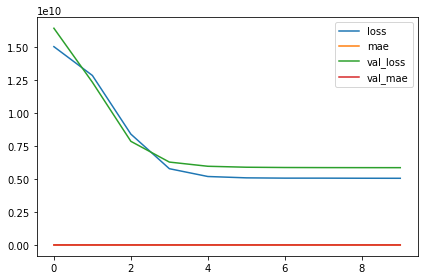

In [20]:
show_history(history)

In [21]:
y_pred = model.predict(X_test_selected_features_nona).ravel()

In [22]:
y_pred[:10]

array([97886.55, 97886.55, 97886.55, 97886.55, 97886.55, 97886.55,
       97886.55, 97886.55, 97886.55, 97886.55], dtype=float32)

In [23]:
df_res = pd.DataFrame({'y_true': df.Consumption.copy()[y_test_no_na.index], 'y_pred': y_pred.ravel()}, index=y_test_no_na_idx)

In [176]:
a = compute_metrics(df_res)

In [25]:
df_res_s = df_res.stack().reset_index().rename({'level_1': 'Type', 0: 'Value'}, axis=1)

In [26]:
px.line(df_res_s, y='Value', x='Datetime', color='Type')

# We can do definitely do better with using all the available features.
- We will difference the data by 24 hours to reduce time-dependency again and add exogenous variables.

In [27]:
X, y = pd.DataFrame(), df.Consumption.copy().diff(24)
for x in trange(24, 1, -1):
    X.loc[:, f'Consumption_lag_{x}'] = df.Consumption.shift(x)
    X.loc[:, f'Consumption_diff_lag_{x}'] = y.shift(x)
    X.loc[:, f'Temperature_lag_{x}'] = df['Temperature'].shift(x)
    X.loc[:, f'Humidity_lag_{x}'] = df['Humidity'].shift(x)
    X.loc[:, f'Cena_lag_{x}'] = df['Cena_bfill'].shift(x)
    
timestamp_s = df.index.map(datetime.datetime.timestamp)
hour = 60*60
day = 24*60*60
week = 7*day
month = (30.4369)*day
year = (365.2425)*day

X['Day_sin'] = np.sin(timestamp_s * (2 * np.pi / day))
X['Day_cos'] = np.cos(timestamp_s * (2 * np.pi / day))
X['Month_sin'] = np.sin(timestamp_s * (2 * np.pi / month))
X['Month_cos'] = np.cos(timestamp_s * (2 * np.pi / month))
X['Week_sin'] = np.sin(timestamp_s * (2 * np.pi / week))
X['Week_cos'] = np.cos(timestamp_s * (2 * np.pi / week))

X['IsSummer'] = 0
X.loc[df.Month.between(6, 8), 'IsSummer'] = 1
X['IsHeatingSeason'] = 1
X.loc[df.Month.between(6, 8), 'IsHeatingSeason'] = 0
X['Temperature'] = df.Temperature
heat_final = X.apply(lambda x: 1 if x['Temperature'] < 13 and x['IsHeatingSeason'] == 1 else 0, axis=1)
X['IsHeatingSeason'] = heat_final
X = X.drop(['Temperature'], axis=1)
X['IsWeekend'] = 0
X.loc[df.Day_of_week.between(6, 7), 'IsWeekend'] = 1
X_train, X_test, y_train, y_test = X[df.TestSet == 0], X[df.TestSet == 1], y[df.TestSet == 0], y[df.TestSet == 1]

  0%|          | 0/23 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1667: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented

In [28]:
X_train_selected_features_nona = X_train.drop(['Residual_diff_from_midnight', 'Year', 'Month', 'Day', 'Hour', 'Day_of_week','Temperature', 'Pressure', 'Pressure2', 'Humidity', 'Wind_direction', 'Wind_speed', 'Phenomena', 'Recent_phenomena', 'Visibility', 'Dewpoint', 'Datetime.1', 'Clouds_low_text', 'Clouds_low_m', 'Clouds_medium_text', 'Clouds_medium_m', 'Clouds_high_text', 'Clouds_high_m', 'Residual', 'ResetSignal', 'IsMissing', 'Cena_bfill', 'TestSet'], axis=1, errors='ignore').dropna()
X_test_selected_features_nona = X_test.drop(['Residual_diff_from_midnight', 'Year', 'Month', 'Day', 'Hour', 'Day_of_week','Temperature', 'Pressure', 'Pressure2', 'Humidity', 'Wind_direction', 'Wind_speed', 'Phenomena', 'Recent_phenomena', 'Visibility', 'Dewpoint', 'Datetime.1', 'Clouds_low_text', 'Clouds_low_m', 'Clouds_medium_text', 'Clouds_medium_m', 'Clouds_high_text', 'Clouds_high_m', 'Residual', 'ResetSignal', 'IsMissing', 'Cena_bfill', 'TestSet'], axis=1, errors='ignore').dropna()
y_train_no_na = y_train.dropna()
y_test_no_na = y_test.dropna()
y_test_no_na_idx = y_test_no_na.index
y_train_no_na = y_train_no_na[y_train_no_na.index.isin(X_train_selected_features_nona.index)]
X_test_selected_features_nona = X_test_selected_features_nona[X_test_selected_features_nona.index.isin(y_test_no_na.index)]
X_train_selected_features_nona.shape, y_train_no_na.shape, X_test_selected_features_nona.shape, y_test_no_na.shape

((43776, 124), (43776,), (8760, 124), (8760,))

## The LSTM benefit if the data are rescaled into the (-1, 1) interval (Do you remember the *tanh* activation function output range?) because there may emerge convergence issues otherwise.

In [29]:
scaler_X = MinMaxScaler(feature_range=(-1, 1)).fit(X_train_selected_features_nona)
X_train_selected_features_nona = scaler_X.transform(X_train_selected_features_nona)
X_test_selected_features_nona = scaler_X.transform(X_test_selected_features_nona)

## Now we can try LSTM model
- The LSTM network expects the input data (X) to be provided with a specific array structure in the form of: [samples, time steps, features].
- We can transform the prepared train and test input data into the expected structure using numpy.reshape()

## Beware that there are two ways of reshaping the data into the [samples, time steps, features] format.
- The first one is perhaps more natural. The exogenous variables together with the consumption data are provided as parallel time series. There is although inconvience with including other dummy variables as they are not time series itself. The feature engineering of using only some lagged variables is problematic as well. The network needs to learn all the patterns from the raw data which leads to very problematic convergence.
- The second approach treats row in the previously engineered dataset as one timestep, we just need to reshape the data.

### Original shape

In [30]:
X_test_selected_features_nona.shape

(8760, 124)

### Transformed shape in [samples, time steps, features] format

In [31]:
X_train_selected_features_nona = X_train_selected_features_nona.reshape(X_train_selected_features_nona.shape[0], 1, X_train_selected_features_nona.shape[1])
X_test_selected_features_nona = X_test_selected_features_nona.reshape(X_test_selected_features_nona.shape[0], 1, X_test_selected_features_nona.shape[1])
X_train_selected_features_nona.shape

(43776, 1, 124)

In [32]:
inp = keras.layers.Input(shape=(X_train_selected_features_nona.shape[1], X_train_selected_features_nona.shape[2]))
x = keras.layers.LSTM(units=64, activation='tanh', return_sequences=True)(inp)
x = keras.layers.GRU(units=32, activation='tanh', return_sequences=False)(x)
x = keras.layers.Dense(64)(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(32)(x)
output_layer = keras.layers.Dense(units=1, activation='linear')(x)

model = keras.Model(inp, output_layer)

model.summary()

model.compile(loss=keras.losses.MeanSquaredError(), optimizer=keras.optimizers.Adam(), metrics=['mae'])

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1, 124)]          0         
                                                                 
 lstm_1 (LSTM)               (None, 1, 64)             48384     
                                                                 
 gru (GRU)                   (None, 32)                9408      
                                                                 
 dense_3 (Dense)             (None, 64)                2112      
                                                                 
 batch_normalization (BatchN  (None, 64)               256       
 ormalization)                                                   
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                           

## Now we can train the model and evaluate the performance.

In [33]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='weights.best.hdf5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

batch_size = 128
history = model.fit(X_train_selected_features_nona, y_train_no_na, epochs=25, batch_size=batch_size, validation_split=0.2, shuffle=False, callbacks=[model_checkpoint_callback])

Epoch 1/25
274/274 [==============================] - 6s 9ms/step - loss: 216084704.0000 - mae: 9682.3096 - val_loss: 220190112.0000 - val_mae: 9818.7559
Epoch 2/25
274/274 [==============================] - 2s 7ms/step - loss: 197677424.0000 - mae: 9149.7861 - val_loss: 171767360.0000 - val_mae: 8637.1074
Epoch 3/25
274/274 [==============================] - 2s 7ms/step - loss: 164194688.0000 - mae: 8346.9160 - val_loss: 131116792.0000 - val_mae: 7821.0059
Epoch 4/25
274/274 [==============================] - 2s 7ms/step - loss: 134133304.0000 - mae: 7742.9180 - val_loss: 110796992.0000 - val_mae: 7386.1045
Epoch 5/25
274/274 [==============================] - 2s 9ms/step - loss: 109309104.0000 - mae: 6879.3154 - val_loss: 88009344.0000 - val_mae: 6993.4751
Epoch 6/25
274/274 [==============================] - 3s 11ms/step - loss: 96355184.0000 - mae: 6521.0337 - val_loss: 76357240.0000 - val_mae: 6385.1177
Epoch 7/25
274/274 [==============================] - 2s 9ms/step - loss: 8881

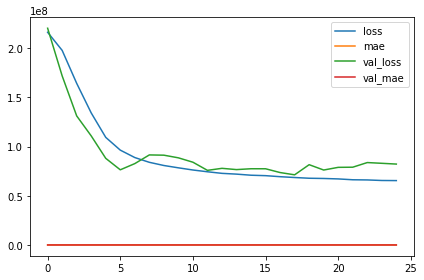

In [34]:
show_history(history)

In [35]:
y_pred = model.predict(X_test_selected_features_nona).ravel()

In [36]:
y_pred[:10]

array([-20591.643 , -16682.627 , -10890.188 ,  -3254.283 ,   1280.9012,
         7053.8296,   6206.765 ,   6526.525 ,   -805.1987, -14420.8125],
      dtype=float32)

In [37]:
y_pred = y_pred + df.Consumption.copy().shift(24)[y_test_no_na.index]

In [38]:
df_res = pd.DataFrame({'y_true': df.Consumption.copy()[y_test_no_na.index], 'y_pred': y_pred.ravel()}, index=y_test_no_na_idx)

In [39]:
compute_metrics(df_res)

MAE           MSE       MAPE      SMAPE        R2
0  7763.674635  8.599152e+07  15.677994  13.745614  0.984646

In [40]:
df_res_s = df_res.stack().reset_index().rename({'level_1': 'Type', 0: 'Value'}, axis=1)

In [41]:
px.line(df_res_s, y='Value', x='Datetime', color='Type')

# We will continue with CNN model
- The preprocessing is very similiar to the LSTM one - we need to reshape our data into the [samples, time_steps, features].
- 1D Convolution layers will then extract features (together with Pooling ones) from the time-series and we can combine them using the Dense layers and make a forecast.

In [42]:
X, y = pd.DataFrame(), df.Consumption.copy().diff(24)
n_steps = 24
n_features = 4
for x in trange(n_steps+1, 1, -1):
    X.loc[:, f'Consumption_lag_{x}'] = df.Consumption.shift(x)
    X.loc[:, f'Consumption_diff_lag_{x}'] = y.shift(x)
    X.loc[:, f'Temperature_lag_{x}'] = df['Temperature'].shift(x)
    X.loc[:, f'Humidity_lag_{x}'] = df['Humidity'].shift(x)
    
timestamp_s = df.index.map(datetime.datetime.timestamp)
hour = 60*60
day = 24*60*60
week = 7*day
month = (30.4369)*day
year = (365.2425)*day

X_dummy = pd.DataFrame(index=df.index)
X_dummy['Day_sin'] = np.sin(timestamp_s * (2 * np.pi / day))
X_dummy['Day_cos'] = np.cos(timestamp_s * (2 * np.pi / day))
X_dummy['Month_sin'] = np.sin(timestamp_s * (2 * np.pi / month))
X_dummy['Month_cos'] = np.cos(timestamp_s * (2 * np.pi / month))
X_dummy['Week_sin'] = np.sin(timestamp_s * (2 * np.pi / week))
X_dummy['Week_cos'] = np.cos(timestamp_s * (2 * np.pi / week))

X_dummy.loc[:, 'IsSummer'] = 0
X_dummy.loc[df.Month.between(6, 8), 'IsSummer'] = 1
X_dummy.loc[:, 'IsHeatingSeason'] = 1
X_dummy.loc[df.Month.between(6, 8), 'IsHeatingSeason'] = 0
X_dummy.loc[:, 'Temperature'] = df.Temperature
heat_final = X_dummy.apply(lambda x: 1 if x['Temperature'] < 13 and x['IsHeatingSeason'] == 1 else 0, axis=1)
X_dummy.loc[:, 'IsHeatingSeason'] = heat_final
X_dummy = X_dummy.drop('Temperature', axis=1)
X_dummy.loc[:, 'IsWeekend'] = 0
X_dummy.loc[df.Day_of_week.between(6, 7), 'IsWeekend'] = 1
X_train, X_test, y_train, y_test = X[df.TestSet == 0], X[df.TestSet == 1], y[df.TestSet == 0], y[df.TestSet == 1]
X_train_dummy, X_test_dummy = X_dummy[df.TestSet == 0], X_dummy[df.TestSet == 1]

  0%|          | 0/24 [00:00<?, ?it/s]

In [43]:
X_train_selected_features_nona = X_train.drop(['Residual_diff_from_midnight', 'Year', 'Month', 'Day', 'Hour', 'Day_of_week','Temperature', 'Pressure', 'Pressure2', 'Humidity', 'Wind_direction', 'Wind_speed', 'Phenomena', 'Recent_phenomena', 'Visibility', 'Dewpoint', 'Datetime.1', 'Clouds_low_text', 'Clouds_low_m', 'Clouds_medium_text', 'Clouds_medium_m', 'Clouds_high_text', 'Clouds_high_m', 'Residual', 'ResetSignal', 'IsMissing', 'Cena_bfill', 'TestSet'], axis=1, errors='ignore').dropna()
X_test_selected_features_nona = X_test.drop(['Residual_diff_from_midnight', 'Year', 'Month', 'Day', 'Hour', 'Day_of_week','Temperature', 'Pressure', 'Pressure2', 'Humidity', 'Wind_direction', 'Wind_speed', 'Phenomena', 'Recent_phenomena', 'Visibility', 'Dewpoint', 'Datetime.1', 'Clouds_low_text', 'Clouds_low_m', 'Clouds_medium_text', 'Clouds_medium_m', 'Clouds_high_text', 'Clouds_high_m', 'Residual', 'ResetSignal', 'IsMissing', 'Cena_bfill', 'TestSet'], axis=1, errors='ignore').dropna()
y_train_no_na = y_train.dropna()
y_test_no_na = y_test.dropna()
y_test_no_na_idx = y_test_no_na.index
y_train_no_na = y_train_no_na[y_train_no_na.index.isin(X_train_selected_features_nona.index)]
X_test_selected_features_nona = X_test_selected_features_nona[X_test_selected_features_nona.index.isin(y_test_no_na.index)]
X_test_dummy = X_test_dummy[X_test_dummy.index.isin(y_test_no_na.index)]
X_train_dummy = X_train_dummy[X_train_dummy.index.isin(y_train_no_na.index)]

X_train_selected_features_nona.shape, y_train_no_na.shape, X_test_selected_features_nona.shape, y_test_no_na.shape, X_train_dummy.shape, X_test_dummy.shape

((43775, 96), (43775,), (8760, 96), (8760,), (43775, 9), (8760, 9))

### Original shape

In [44]:
X_test_selected_features_nona.shape

(8760, 96)

### Transformed shape in [samples, time steps, features] format

In [45]:
X_train_selected_features_nona = X_train_selected_features_nona.values.reshape(X_train_selected_features_nona.shape[0], n_steps, n_features)
X_test_selected_features_nona = X_test_selected_features_nona.values.reshape(X_test_selected_features_nona.shape[0], n_steps, n_features)
X_train_selected_features_nona.shape

(43775, 24, 4)

# Non-time series data needs to be included through separate Input layer and mixed with extracted features later in the model. There is no point in including these features in the Conv layer - there are no signal-related characteristics to extract.

In [46]:
inp = keras.layers.Input(shape=(X_train_selected_features_nona.shape[1], X_train_selected_features_nona.shape[2]))
dummy_inp = keras.layers.Input(shape=(X_dummy.shape[1]))


x = keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu')(inp)
x = keras.layers.MaxPool1D(pool_size=2)(x)
x = keras.layers.Flatten()(x)

cnc = keras.layers.concatenate([x, dummy_inp])

x = keras.layers.Dense(64)(cnc)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(32)(x)
output_layer = keras.layers.Dense(units=1, activation='linear')(x)

model = keras.Model([inp, dummy_inp], output_layer)

model.summary()

model.compile(loss=keras.losses.MeanSquaredError(), optimizer=keras.optimizers.Adam(), metrics=['mae'])

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 24, 4)]      0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 22, 32)       416         ['input_3[0][0]']                
                                                                                                  
 max_pooling1d (MaxPooling1D)   (None, 11, 32)       0           ['conv1d[0][0]']                 
                                                                                                  
 flatten (Flatten)              (None, 352)          0           ['max_pooling1d[0][0]']          
                                                                                            

## Now we can train the model and evaluate the performance.

In [47]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='weights.best.hdf5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

batch_size = 128
history = model.fit([X_train_selected_features_nona, X_train_dummy], y_train_no_na, epochs=25, batch_size=batch_size, validation_split=0.2, shuffle=False, callbacks=[model_checkpoint_callback])

Epoch 1/25
274/274 [==============================] - 9s 5ms/step - loss: 215940416.0000 - mae: 9676.7236 - val_loss: 219255024.0000 - val_mae: 9832.2744
Epoch 2/25
274/274 [==============================] - 1s 4ms/step - loss: 197535600.0000 - mae: 9140.6240 - val_loss: 180253936.0000 - val_mae: 8922.2139
Epoch 3/25
274/274 [==============================] - 2s 6ms/step - loss: 164060912.0000 - mae: 8308.8066 - val_loss: 129777584.0000 - val_mae: 7812.1455
Epoch 4/25
274/274 [==============================] - 2s 8ms/step - loss: 136889712.0000 - mae: 7858.1777 - val_loss: 107618168.0000 - val_mae: 7483.1582
Epoch 5/25
274/274 [==============================] - 2s 7ms/step - loss: 125871864.0000 - mae: 7780.4014 - val_loss: 126663912.0000 - val_mae: 8279.2598
Epoch 6/25
274/274 [==============================] - 2s 6ms/step - loss: 122111112.0000 - mae: 7779.1289 - val_loss: 167665888.0000 - val_mae: 9565.1572
Epoch 7/25
274/274 [==============================] - 1s 4ms/step - loss: 11

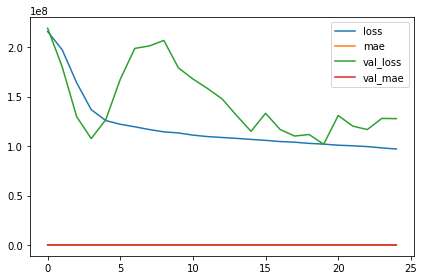

In [48]:
show_history(history)

In [49]:
y_pred = model.predict([X_test_selected_features_nona, X_test_dummy]).ravel()

In [50]:
y_pred[:10]

array([-35295.543 , -32182.064 , -24354.865 , -18045.035 , -15052.335 ,
       -15721.5205, -13844.889 , -11873.909 , -12553.594 , -22305.494 ],
      dtype=float32)

In [51]:
y_pred = y_pred + df.Consumption.copy().shift(24)[y_test_no_na.index]

In [52]:
df_res = pd.DataFrame({'y_true': df.Consumption.copy()[y_test_no_na.index], 'y_pred': y_pred.ravel()}, index=y_test_no_na_idx)

In [53]:
compute_metrics(df_res)

MAE           MSE       MAPE      SMAPE        R2
0  8361.472686  1.100010e+08  13.263152  12.136152  0.980359

In [54]:
df_res_s = df_res.stack().reset_index().rename({'level_1': 'Type', 0: 'Value'}, axis=1)

In [55]:
px.line(df_res_s, y='Value', x='Datetime', color='Type')

# Finally we can mix CNN and LSTM models together.
## We will use the [TimeDistributed](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TimeDistributed) layers in the model. 

- Consider a batch of 32 video samples, where each sample is a 128x128 RGB image with channels_last data format, across 10 timesteps. The batch input shape is (32, 10, 128, 128, 3).
- You can then use TimeDistributed to apply the same Conv2D layer to each of the 10 timesteps, independently:
- **Because TimeDistributed applies the same instance of Conv2D to each of the timestamps, the same set of weights are used at each timestamp.**

In [56]:
X, y = pd.DataFrame(), df.Consumption.copy().diff(24)
n_steps = 24
n_features = 4
for x in trange(n_steps+1, 1, -1):
    X.loc[:, f'Consumption_lag_{x}'] = df.Consumption.shift(x)
    X.loc[:, f'Consumption_diff_lag_{x}'] = y.shift(x)
    X.loc[:, f'Temperature_lag_{x}'] = df['Temperature'].shift(x)
    X.loc[:, f'Humidity_lag_{x}'] = df['Humidity'].shift(x)
    
timestamp_s = df.index.map(datetime.datetime.timestamp)
hour = 60*60
day = 24*60*60
week = 7*day
month = (30.4369)*day
year = (365.2425)*day

X_dummy = pd.DataFrame(index=df.index)
X_dummy['Day_sin'] = np.sin(timestamp_s * (2 * np.pi / day))
X_dummy['Day_cos'] = np.cos(timestamp_s * (2 * np.pi / day))
X_dummy['Month_sin'] = np.sin(timestamp_s * (2 * np.pi / month))
X_dummy['Month_cos'] = np.cos(timestamp_s * (2 * np.pi / month))
X_dummy['Week_sin'] = np.sin(timestamp_s * (2 * np.pi / week))
X_dummy['Week_cos'] = np.cos(timestamp_s * (2 * np.pi / week))

X_dummy.loc[:, 'IsSummer'] = 0
X_dummy.loc[df.Month.between(6, 8), 'IsSummer'] = 1
X_dummy.loc[:, 'IsHeatingSeason'] = 1
X_dummy.loc[df.Month.between(6, 8), 'IsHeatingSeason'] = 0
X_dummy.loc[:, 'Temperature'] = df.Temperature
heat_final = X_dummy.apply(lambda x: 1 if x['Temperature'] < 13 and x['IsHeatingSeason'] == 1 else 0, axis=1)
X_dummy.loc[:, 'IsHeatingSeason'] = heat_final
X_dummy = X_dummy.drop('Temperature', axis=1)
X_dummy.loc[:, 'IsWeekend'] = 0
X_dummy.loc[df.Day_of_week.between(6, 7), 'IsWeekend'] = 1
X_train, X_test, y_train, y_test = X[df.TestSet == 0], X[df.TestSet == 1], y[df.TestSet == 0], y[df.TestSet == 1]
X_train_dummy, X_test_dummy = X_dummy[df.TestSet == 0], X_dummy[df.TestSet == 1]

  0%|          | 0/24 [00:00<?, ?it/s]

In [57]:
X_train_selected_features_nona = X_train.drop(['Residual_diff_from_midnight', 'Year', 'Month', 'Day', 'Hour', 'Day_of_week','Temperature', 'Pressure', 'Pressure2', 'Humidity', 'Wind_direction', 'Wind_speed', 'Phenomena', 'Recent_phenomena', 'Visibility', 'Dewpoint', 'Datetime.1', 'Clouds_low_text', 'Clouds_low_m', 'Clouds_medium_text', 'Clouds_medium_m', 'Clouds_high_text', 'Clouds_high_m', 'Residual', 'ResetSignal', 'IsMissing', 'Cena_bfill', 'TestSet'], axis=1, errors='ignore').dropna()
X_test_selected_features_nona = X_test.drop(['Residual_diff_from_midnight', 'Year', 'Month', 'Day', 'Hour', 'Day_of_week','Temperature', 'Pressure', 'Pressure2', 'Humidity', 'Wind_direction', 'Wind_speed', 'Phenomena', 'Recent_phenomena', 'Visibility', 'Dewpoint', 'Datetime.1', 'Clouds_low_text', 'Clouds_low_m', 'Clouds_medium_text', 'Clouds_medium_m', 'Clouds_high_text', 'Clouds_high_m', 'Residual', 'ResetSignal', 'IsMissing', 'Cena_bfill', 'TestSet'], axis=1, errors='ignore').dropna()
y_train_no_na = y_train.dropna()
y_test_no_na = y_test.dropna()
y_test_no_na_idx = y_test_no_na.index
y_train_no_na = y_train_no_na[y_train_no_na.index.isin(X_train_selected_features_nona.index)]
X_test_selected_features_nona = X_test_selected_features_nona[X_test_selected_features_nona.index.isin(y_test_no_na.index)]
X_test_dummy = X_test_dummy[X_test_dummy.index.isin(y_test_no_na.index)]
X_train_dummy = X_train_dummy[X_train_dummy.index.isin(y_train_no_na.index)]

X_train_selected_features_nona.shape, y_train_no_na.shape, X_test_selected_features_nona.shape, y_test_no_na.shape, X_train_dummy.shape, X_test_dummy.shape

((43775, 96), (43775,), (8760, 96), (8760,), (43775, 9), (8760, 9))

# Beware that now we need to use format of [samples, subsequences, timesteps, features]!

In [58]:
X_train_selected_features_nona = X_train_selected_features_nona.values.reshape(X_train_selected_features_nona.shape[0], 2, n_steps//2, n_features)
X_test_selected_features_nona = X_test_selected_features_nona.values.reshape(X_test_selected_features_nona.shape[0], 2, n_steps//2, n_features)
X_train_selected_features_nona.shape

(43775, 2, 12, 4)

In [59]:
inp = keras.layers.Input(shape=(X_train_selected_features_nona.shape[1:]))

x = keras.layers.TimeDistributed(keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu'))(inp)
x = keras.layers.TimeDistributed(keras.layers.MaxPool1D(pool_size=2))(x)
x = keras.layers.TimeDistributed(keras.layers.Flatten())(x)
x = keras.layers.Bidirectional(keras.layers.LSTM(units=160, activation='tanh', return_sequences=False))(x)
x = keras.layers.Dense(64)(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(32)(x)
output_layer = keras.layers.Dense(units=1, activation='linear')(x)

model = keras.Model(inp, output_layer)

model.summary()

model.compile(loss=keras.losses.MeanSquaredError(), optimizer=keras.optimizers.Adam(), metrics=['mae'])

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 2, 12, 4)]        0         
                                                                 
 time_distributed (TimeDistr  (None, 2, 10, 32)        416       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 2, 5, 32)         0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 2, 160)           0         
 tributed)                                                       
                                                                 
 bidirectional (Bidirectiona  (None, 320)              410880    
 l)                                                        

## Now we can train the model and evaluate the performance.

In [60]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='weights.best.hdf5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

batch_size = 128
history = model.fit(X_train_selected_features_nona, y_train_no_na, epochs=25, batch_size=batch_size, validation_split=0.2, shuffle=False, callbacks=[model_checkpoint_callback])

Epoch 1/25
274/274 [==============================] - 12s 18ms/step - loss: 218716960.0000 - mae: 9759.8232 - val_loss: 233749904.0000 - val_mae: 10161.7275
Epoch 2/25
274/274 [==============================] - 2s 7ms/step - loss: 218702544.0000 - mae: 9759.1133 - val_loss: 233868896.0000 - val_mae: 10159.5039
Epoch 3/25
274/274 [==============================] - 2s 7ms/step - loss: 218728832.0000 - mae: 9759.9492 - val_loss: 233842464.0000 - val_mae: 10173.6943
Epoch 4/25
274/274 [==============================] - 2s 9ms/step - loss: 218767808.0000 - mae: 9761.5078 - val_loss: 233862352.0000 - val_mae: 10160.4453
Epoch 5/25
274/274 [==============================] - 3s 11ms/step - loss: 218743952.0000 - mae: 9761.2432 - val_loss: 233745840.0000 - val_mae: 10167.8789
Epoch 6/25
274/274 [==============================] - 3s 10ms/step - loss: 218724160.0000 - mae: 9760.4297 - val_loss: 233705712.0000 - val_mae: 10156.1787
Epoch 7/25
274/274 [==============================] - 3s 10ms/step

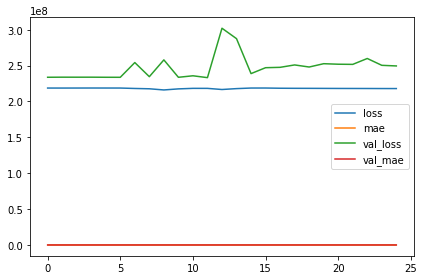

In [61]:
show_history(history)

In [62]:
y_pred = model.predict(X_test_selected_features_nona).ravel()

In [63]:
y_pred[:10]

array([-4123.993, -4123.993, -4123.993, -4123.993, -4123.993, -4123.993,
       -4123.993, -4123.993, -4123.993, -4123.993], dtype=float32)

In [64]:
y_pred = y_pred + df.Consumption.copy().shift(24)[y_test_no_na.index]

In [65]:
df_res = pd.DataFrame({'y_true': df.Consumption.copy()[y_test_no_na.index], 'y_pred': y_pred.ravel()}, index=y_test_no_na_idx)

In [66]:
compute_metrics(df_res)

MAE           MSE       MAPE      SMAPE        R2
0  10172.989959  2.113783e+08  12.896743  13.764332  0.962259

In [67]:
df_res_s = df_res.stack().reset_index().rename({'level_1': 'Type', 0: 'Value'}, axis=1)

In [68]:
px.line(df_res_s, y='Value', x='Datetime', color='Type')

# Bonus: How to forecast multiple timesteps in the future?
This task is much simpler than in the ML approach in the last lecture.

We have specified only a single neuron as an output in our models so far. It is no problem to use multiple output neurons and output vector instead of scalar value.

Number of output neurons is equal to number of timesteps you want to forecast.

- Alternatively, you can use [TimeDistributed](https://machinelearningmastery.com/timedistributed-layer-for-long-short-term-memory-networks-in-python/) layer with carefully designed network architecture.

## The forecast horizon of 24 hours starting at midnight will be used.

In [69]:
X, y = pd.DataFrame(), df.Consumption.copy()
n_steps = 24
n_features = 3
for x in trange(n_steps+1, 0, -1):
    X.loc[:, f'Consumption_lag_{x}'] = df.Consumption.shift(x)
    X.loc[:, f'Temperature_lag_{x}'] = df['Temperature'].shift(x)
    X.loc[:, f'Humidity_lag_{x}'] = df['Humidity'].shift(x)
    
timestamp_s = df.index.map(datetime.datetime.timestamp)
hour = 60*60
day = 24*60*60
week = 7*day
month = (30.4369)*day
year = (365.2425)*day

X_dummy = pd.DataFrame(index=df.index)
X_dummy['Day_sin'] = np.sin(timestamp_s * (2 * np.pi / day))
X_dummy['Day_cos'] = np.cos(timestamp_s * (2 * np.pi / day))
X_dummy['Month_sin'] = np.sin(timestamp_s * (2 * np.pi / month))
X_dummy['Month_cos'] = np.cos(timestamp_s * (2 * np.pi / month))
X_dummy['Week_sin'] = np.sin(timestamp_s * (2 * np.pi / week))
X_dummy['Week_cos'] = np.cos(timestamp_s * (2 * np.pi / week))

X_dummy.loc[:, 'IsSummer'] = 0
X_dummy.loc[df.Month.between(6, 8), 'IsSummer'] = 1
X_dummy.loc[:, 'IsHeatingSeason'] = 1
X_dummy.loc[df.Month.between(6, 8), 'IsHeatingSeason'] = 0
X_dummy.loc[:, 'Temperature'] = df.Temperature
heat_final = X_dummy.apply(lambda x: 1 if x['Temperature'] < 13 and x['IsHeatingSeason'] == 1 else 0, axis=1)
X_dummy.loc[:, 'IsHeatingSeason'] = heat_final
X_dummy = X_dummy.drop('Temperature', axis=1)
X_dummy.loc[:, 'IsWeekend'] = 0
X_dummy.loc[df.Day_of_week.between(6, 7), 'IsWeekend'] = 1

y_vec = pd.DataFrame()
for x in range(1, 25):
    y_vec.loc[:, f'T+{x}'] = y.shift(-x)
    
X_train, X_test, y_train, y_test = X[df.TestSet == 0], X[df.TestSet == 1], y_vec[df.TestSet == 0], y_vec[df.TestSet == 1]
X_train_dummy, X_test_dummy = X_dummy[df.TestSet == 0], X_dummy[df.TestSet == 1]

  0%|          | 0/25 [00:00<?, ?it/s]

In [70]:
X_train_selected_features_nona = X_train.drop(['Residual_diff_from_midnight', 'Year', 'Month', 'Day', 'Hour', 'Day_of_week','Temperature', 'Pressure', 'Pressure2', 'Humidity', 'Wind_direction', 'Wind_speed', 'Phenomena', 'Recent_phenomena', 'Visibility', 'Dewpoint', 'Datetime.1', 'Clouds_low_text', 'Clouds_low_m', 'Clouds_medium_text', 'Clouds_medium_m', 'Clouds_high_text', 'Clouds_high_m', 'Residual', 'ResetSignal', 'IsMissing', 'Cena_bfill', 'TestSet'], axis=1, errors='ignore').dropna()
X_test_selected_features_nona = X_test.drop(['Residual_diff_from_midnight', 'Year', 'Month', 'Day', 'Hour', 'Day_of_week','Temperature', 'Pressure', 'Pressure2', 'Humidity', 'Wind_direction', 'Wind_speed', 'Phenomena', 'Recent_phenomena', 'Visibility', 'Dewpoint', 'Datetime.1', 'Clouds_low_text', 'Clouds_low_m', 'Clouds_medium_text', 'Clouds_medium_m', 'Clouds_high_text', 'Clouds_high_m', 'Residual', 'ResetSignal', 'IsMissing', 'Cena_bfill', 'TestSet'], axis=1, errors='ignore').dropna()
y_train_no_na = y_train.dropna()
y_test_no_na = y_test.dropna()
y_test_no_na_idx = y_test_no_na.index
y_train_no_na = y_train_no_na[y_train_no_na.index.isin(X_train_selected_features_nona.index)]
X_test_selected_features_nona = X_test_selected_features_nona[X_test_selected_features_nona.index.isin(y_test_no_na.index)]
X_test_dummy = X_test_dummy[X_test_dummy.index.isin(y_test_no_na.index)]
X_train_dummy = X_train_dummy[X_train_dummy.index.isin(y_train_no_na.index)]

X_train_selected_features_nona.shape, y_train_no_na.shape, X_test_selected_features_nona.shape, y_test_no_na.shape, X_train_dummy.shape, X_test_dummy.shape

((43799, 75), (43799, 24), (8736, 75), (8736, 24), (43799, 9), (8736, 9))

### Original shape

In [71]:
X_test_selected_features_nona.shape

(8736, 75)

### Transformed shape in [samples, time steps, features] format

In [72]:
X_train_selected_features_nona = X_train_selected_features_nona.values.reshape(X_train_selected_features_nona.shape[0], n_steps+1, n_features)
X_test_selected_features_nona = X_test_selected_features_nona.values.reshape(X_test_selected_features_nona.shape[0], n_steps+1, n_features)
X_train_selected_features_nona.shape

(43799, 25, 3)

In [73]:
inp = keras.layers.Input(shape=(X_train_selected_features_nona.shape[1], X_train_selected_features_nona.shape[2]))
dummy_inp = keras.layers.Input(shape=(X_dummy.shape[1]))


x_1 = keras.layers.Conv1D(filters=64, kernel_size=5, activation='relu')(inp)
x_2 = keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu')(inp)

x_mp1 = keras.layers.MaxPool1D(pool_size=2)(x_1)
x_mp2 = keras.layers.MaxPool1D(pool_size=2)(x_2)
x_flt_1 = keras.layers.Flatten()(x_mp1)
x_flt_2 = keras.layers.Flatten()(x_mp2)

cnc = keras.layers.concatenate([x_flt_1, x_flt_2, dummy_inp])

x = keras.layers.Dense(128)(cnc)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(64)(x)
output_layer = keras.layers.Dense(units=y_train_no_na.shape[1], activation='linear')(x)

model = keras.Model([inp, dummy_inp], output_layer)

model.summary()

model.compile(loss=keras.losses.MeanSquaredError(), optimizer=keras.optimizers.Adam(), metrics=['mae'])

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 25, 3)]      0           []                               
                                                                                                  
 conv1d_2 (Conv1D)              (None, 21, 64)       1024        ['input_6[0][0]']                
                                                                                                  
 conv1d_3 (Conv1D)              (None, 23, 64)       640         ['input_6[0][0]']                
                                                                                                  
 max_pooling1d_2 (MaxPooling1D)  (None, 10, 64)      0           ['conv1d_2[0][0]']               
                                                                                            

## Now we can train the model and evaluate the performance.

In [74]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='weights.best.hdf5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

batch_size = 256
history = model.fit([X_train_selected_features_nona, X_train_dummy], y_train_no_na, epochs=50, batch_size=batch_size, validation_split=0.2, shuffle=False, callbacks=[model_checkpoint_callback])

Epoch 1/50
137/137 [==============================] - 2s 7ms/step - loss: 15219661824.0000 - mae: 101739.0781 - val_loss: 16695128064.0000 - val_mae: 105532.6094
Epoch 2/50
137/137 [==============================] - 1s 6ms/step - loss: 15165095936.0000 - mae: 101528.6953 - val_loss: 16647261184.0000 - val_mae: 107743.1484
Epoch 3/50
137/137 [==============================] - 1s 6ms/step - loss: 14939722752.0000 - mae: 100555.2891 - val_loss: 14704215040.0000 - val_mae: 105655.6094
Epoch 4/50
137/137 [==============================] - 1s 6ms/step - loss: 14461460480.0000 - mae: 98293.0391 - val_loss: 11256031232.0000 - val_mae: 97563.4219
Epoch 5/50
137/137 [==============================] - 1s 6ms/step - loss: 13702852608.0000 - mae: 94428.5938 - val_loss: 10964321280.0000 - val_mae: 99214.7031
Epoch 6/50
137/137 [==============================] - 1s 5ms/step - loss: 12659004416.0000 - mae: 88845.4062 - val_loss: 9521637376.0000 - val_mae: 93363.6797
Epoch 7/50
137/137 [===============

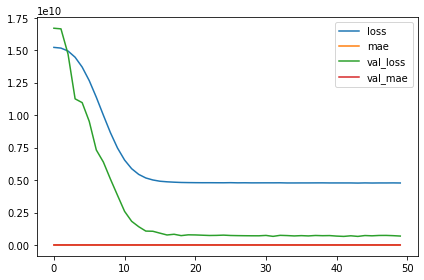

In [75]:
show_history(history)

In [76]:
y_pred = model.predict([X_test_selected_features_nona, X_test_dummy])

In [77]:
y_pred = pd.DataFrame(y_pred, index=pd.to_datetime(y_test_no_na.index), columns=y_vec.columns)

In [78]:
y_pred.head()

T+1            T+2            T+3  \
Datetime                                                           
2018-01-01 00:00:00  127994.187500  127920.398438  127894.046875   
2018-01-01 01:00:00  126204.593750  126130.820312  126106.812500   
2018-01-01 02:00:00  128816.429688  128739.531250  128716.218750   
2018-01-01 03:00:00  133028.500000  132947.046875  132923.562500   
2018-01-01 04:00:00  132503.343750  132420.984375  132396.843750   

                               T+4            T+5            T+6  \
Datetime                                                           
2018-01-01 00:00:00  127850.226562  127813.015625  127763.742188   
2018-01-01 01:00:00  126061.921875  126025.984375  125975.531250   
2018-01-01 02:00:00  128668.531250  128632.078125  128579.484375   
2018-01-01 03:00:00  132872.187500  132834.296875  132779.484375   
2018-01-01 04:00:00  132345.359375  132306.812500  132253.000000   

                               T+7            T+8            T+9  \
Datetime                                                           
2018-01-01 00:00:00  127778.906250  127746.507812  127725.250000   
2018-01-01 01:00:00  125991.875000  125956.000000  125936.304688   
2018-01-01 02:00:00  128596.000000  128556.742188  128538.625000   
2018-01-01 03:00:00  132794.984375  132752.968750  132736.796875   
2018-01-01 04:00:00  132266.781250  132225.265625  132210.609375   

                              T+10  ...           T+15           T+16  \
Datetime                            ...                                 
2018-01-01 00:00:00  127674.460938  ...  127588.078125  127651.859375   
2018-01-01 01:00:00  125886.750000  ...  125803.921875  125868.890625   
2018-01-01 02:00:00  128488.937500  ...  128406.078125  128472.648438   
2018-01-01 03:00:00  132686.500000  ...  132602.093750  132670.015625   
2018-01-01 04:00:00  132161.031250  ...  132076.718750  132142.531250   

                              T+17           T+18           T+19  \
Datetime                                                           
2018-01-01 00:00:00  127647.375000  127630.101562  127628.710938   
2018-01-01 01:00:00  125863.531250  125847.281250  125843.882812   
2018-01-01 02:00:00  128466.171875  128449.695312  128445.406250   
2018-01-01 03:00:00  132662.328125  132645.015625  132640.703125   
2018-01-01 04:00:00  132134.656250  132116.921875  132113.562500   

                              T+20           T+21           T+22  \
Datetime                                                           
2018-01-01 00:00:00  127642.585938  127645.203125  127580.125000   
2018-01-01 01:00:00  125857.703125  125860.210938  125790.679688   
2018-01-01 02:00:00  128458.125000  128461.179688  128387.500000   
2018-01-01 03:00:00  132651.250000  132655.562500  132578.343750   
2018-01-01 04:00:00  132122.046875  132126.968750  132051.921875   

                              T+23           T+24  
Datetime                                           
2018-01-01 00:00:00  127510.335938  127400.328125  
2018-01-01 01:00:00  125724.679688  125619.085938  
2018-01-01 02:00:00  128322.656250  128218.523438  
2018-01-01 03:00:00  132513.671875  132410.187500  
2018-01-01 04:00:00  131987.875000  131886.828125  

[5 rows x 24 columns]

## Now we need to extract only forecasts created at midnight

In [79]:
y_pred = pd.Series(y_pred[y_pred.index.hour == 0].stack().values, index=y_test_no_na_idx)
y_pred.head()

Datetime
2018-01-01 00:00:00    127994.187500
2018-01-01 01:00:00    127920.398438
2018-01-01 02:00:00    127894.046875
2018-01-01 03:00:00    127850.226562
2018-01-01 04:00:00    127813.015625
dtype: float32

In [80]:
df_res = pd.DataFrame({'y_true': df.Consumption.copy()[y_test_no_na.index], 'y_pred': y_pred.ravel()}, index=y_test_no_na_idx)

In [81]:
compute_metrics(df_res)

MAE           MSE       MAPE      SMAPE        R2
0  21708.576316  6.432566e+08  41.820195  31.301284  0.885233

In [82]:
df_res_s = df_res.stack().reset_index().rename({'level_1': 'Type', 0: 'Value'}, axis=1)

### We can see that the model more-or-less captured underlaying trend in the data
- The forecasts are very imprecise - it's rather flat
- The summer levels are totally incorrect

#### What do you propose for making the model better? Any ideas or techniques from the last lecture you would like to try?

In [83]:
px.line(df_res_s, y='Value', x='Datetime', color='Type')

# Tasks for the rest of the lecture
1. Try to modify any of the proposed models or create a new one from scratch.
2. Optional - use any preprocessing technique you would like to try (STL, standardizing/normalizing inputs etc.) with any chosen model.
3. Compare the new model with the original one. Did the MAE, MSE etc changed? If it did, how (is it better or worse, do you have any idea why)?

In [186]:
results = {}

# Testování batch size a optimizer

# Testování sítě se sigmoidem

In [187]:
y_train, y_test = y[df.TestSet == 0], y[df.TestSet == 1]

In [188]:
X_train_selected_features_nona = X_train.drop(['Residual_diff_from_midnight', 'Year', 'Month', 'Day', 'Hour', 'Day_of_week','Temperature', 'Pressure', 'Pressure2', 'Humidity', 'Wind_direction', 'Wind_speed', 'Phenomena', 'Recent_phenomena', 'Visibility', 'Dewpoint', 'Datetime.1', 'Clouds_low_text', 'Clouds_low_m', 'Clouds_medium_text', 'Clouds_medium_m', 'Clouds_high_text', 'Clouds_high_m', 'Residual', 'ResetSignal', 'IsMissing', 'Cena_bfill', 'TestSet'], axis=1, errors='ignore').dropna()
X_test_selected_features_nona = X_test.drop(['Residual_diff_from_midnight', 'Year', 'Month', 'Day', 'Hour', 'Day_of_week','Temperature', 'Pressure', 'Pressure2', 'Humidity', 'Wind_direction', 'Wind_speed', 'Phenomena', 'Recent_phenomena', 'Visibility', 'Dewpoint', 'Datetime.1', 'Clouds_low_text', 'Clouds_low_m', 'Clouds_medium_text', 'Clouds_medium_m', 'Clouds_high_text', 'Clouds_high_m', 'Residual', 'ResetSignal', 'IsMissing', 'Cena_bfill', 'TestSet'], axis=1, errors='ignore').dropna()
y_train_no_na = y_train.dropna()
y_test_no_na = y_test.dropna()
y_test_no_na_idx = y_test_no_na.index
y_train_no_na = y_train_no_na[y_train_no_na.index.isin(X_train_selected_features_nona.index)]
X_test_selected_features_nona = X_test_selected_features_nona[X_test_selected_features_nona.index.isin(y_test_no_na.index)]
X_train_selected_features_nona.shape, y_train_no_na.shape, X_test_selected_features_nona.shape, y_test_no_na.shape

((43799, 75), (43799,), (8760, 75), (8760,))

In [189]:
#Normalization X
scaler_X = MinMaxScaler(feature_range=(0, 1)).fit(X_train_selected_features_nona)
X_train_selected_features_nona = scaler_X.transform(X_train_selected_features_nona)
X_test_selected_features_nona = scaler_X.transform(X_test_selected_features_nona)

In [190]:
y_train_no_na.values

array([137748., 136988., 137768., ..., 135699., 121647., 114048.])

In [191]:
y_train_no_na_copy = y_train_no_na.copy()
y_test_no_na_copy = y_test_no_na.copy() 

In [192]:
#Normalization y
scaler_y = MinMaxScaler(feature_range=(0, 1)).fit(np.array(y_train_no_na).reshape(-1, 1))
y_train_no_na = scaler_y.transform(np.array(y_train_no_na).reshape(-1, 1))
y_test_no_na = scaler_y.transform(np.array(y_test_no_na).reshape(-1, 1))

In [193]:
y_train_no_na[0]

array([0.4145836])

In [194]:
X_train_selected_features_nona = X_train_selected_features_nona.reshape(X_train_selected_features_nona.shape[0], 1, X_train_selected_features_nona.shape[1])
X_test_selected_features_nona = X_test_selected_features_nona.reshape(X_test_selected_features_nona.shape[0], 1, X_test_selected_features_nona.shape[1])
X_train_selected_features_nona.shape

(43799, 1, 75)

In [195]:
X_train_selected_features_nona[0]

array([[0.44123964, 0.30909091, 0.8452381 , 0.4501089 , 0.29090909,
        0.83333333, 0.45573214, 0.30909091, 0.8452381 , 0.4588937 ,
        0.29090909, 0.91666667, 0.48224338, 0.30909091, 0.8452381 ,
        0.54733289, 0.30909091, 0.8452381 , 0.60708877, 0.29090909,
        0.91666667, 0.5932841 , 0.29090909, 0.91666667, 0.58884344,
        0.30909091, 0.8452381 , 0.59249974, 0.32727273, 0.77380952,
        0.57494223, 0.32727273, 0.77380952, 0.57093598, 0.34545455,
        0.77380952, 0.55059098, 0.36363636, 0.70238095, 0.5591827 ,
        0.38181818, 0.64285714, 0.56616951, 0.38181818, 0.64285714,
        0.59066556, 0.38181818, 0.70238095, 0.61011759, 0.36363636,
        0.70238095, 0.60372207, 0.36363636, 0.70238095, 0.60637682,
        0.36363636, 0.70238095, 0.60427716, 0.36363636, 0.70238095,
        0.59032768, 0.34545455, 0.77380952, 0.54956529, 0.34545455,
        0.77380952, 0.50095933, 0.34545455, 0.77380952, 0.44501662,
        0.34545455, 0.8452381 , 0.42281331, 0.36

In [196]:
y_train_no_na[0]

array([0.4145836])

In [197]:
import itertools

In [198]:
BATCH_SIZES = [32, 64, 128, 256]
OPTIMIZERS = [keras.optimizers.Adam(), keras.optimizers.RMSprop()]
LOSS = [keras.losses.MeanSquaredError()]

In [199]:
experiments = list(itertools.product(BATCH_SIZES, OPTIMIZERS, LOSS))

Model: "model_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_37 (InputLayer)       [(None, 1, 75)]           0         
                                                                 
 lstm_32 (LSTM)              (None, 1, 64)             35840     
                                                                 
 dense_102 (Dense)           (None, 1, 64)             4160      
                                                                 
 dropout_34 (Dropout)        (None, 1, 64)             0         
                                                                 
 dense_103 (Dense)           (None, 1, 32)             2080      
                                                                 
 dense_104 (Dense)           (None, 1, 1)              33        
                                                                 
Total params: 42,113
Trainable params: 42,113
Non-trainabl

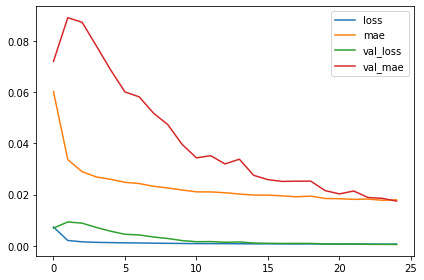

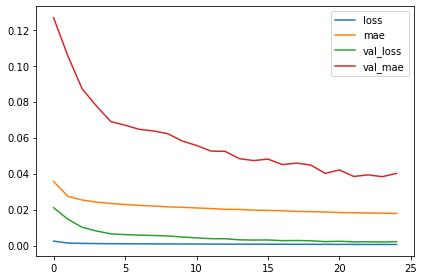

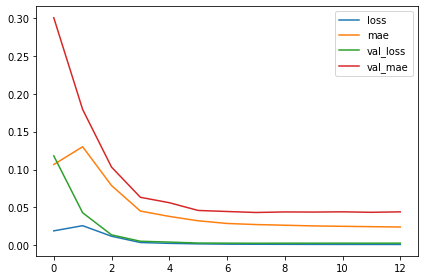

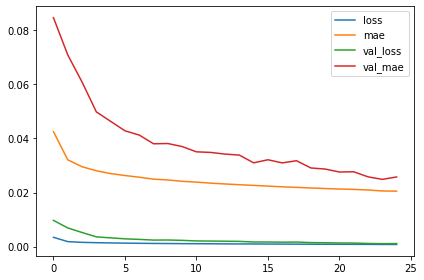

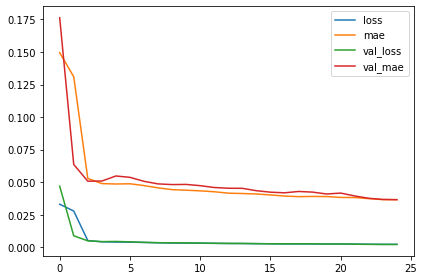

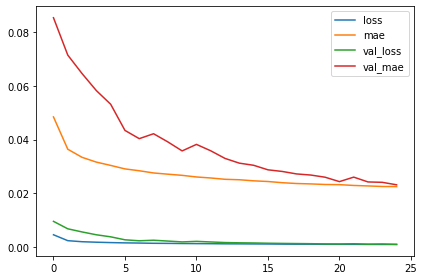

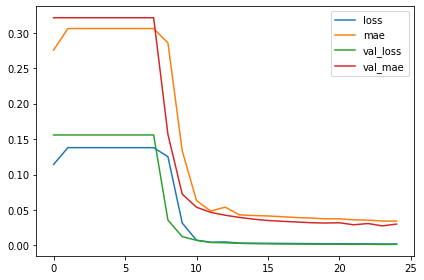

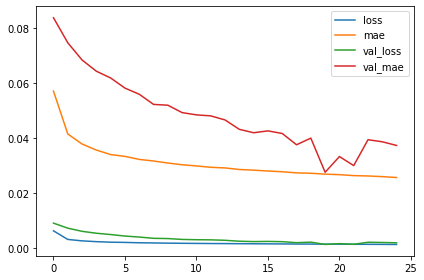

In [200]:
for batch_size, optimizer, loss in experiments:

  inp = keras.layers.Input(shape=(X_train_selected_features_nona.shape[1], X_train_selected_features_nona.shape[2]))
  x = keras.layers.LSTM(units=64, return_sequences=True)(inp)
  x = keras.layers.Dense(64)(x)
  x = keras.layers.Dropout(0.2)(x)
  x = keras.layers.Dense(32)(x)
  output_layer = keras.layers.Dense(units=1, activation='sigmoid')(x)

  model = keras.Model(inp, output_layer)

  model.summary()

  model.compile(loss=loss, optimizer=optimizer, metrics=['mae'])


  model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
      filepath='weights.best.hdf5',
      save_weights_only=True,
      monitor='val_loss',
      mode='auto',
      save_best_only=True)

  history = model.fit(X_train_selected_features_nona, y_train_no_na, epochs=25, batch_size=batch_size, validation_split=0.2, shuffle=False, callbacks=[model_checkpoint_callback, tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, mode="auto")])

  show_history(history)

  y_pred = model.predict(X_test_selected_features_nona).ravel()

  y_pred_true = scaler_y.inverse_transform(y_pred.ravel().reshape(-1, 1))


  df_res = pd.DataFrame({'y_true': df.Consumption.copy()[y_test_no_na_copy.index], 'y_pred': y_pred_true.flatten()}, index=y_test_no_na_idx)

  res = compute_metrics(df_res).T.to_dict()[0]

  current = len(list(results.keys()))

  v = {
      "BatchSize": batch_size,
       "Optimizer": type(optimizer).__name__,
       "Loss": type(loss).__name__,
  }

  results[current+1] = {
      **v,
      **res
  }


In [201]:
results

{1: {'BatchSize': 32,
  'Loss': 'MeanSquaredError',
  'MAE': 6080.9769524204485,
  'MAPE': 11.417628232846537,
  'MSE': 59484469.2434314,
  'Optimizer': 'Adam',
  'R2': 0.9893791155752548,
  'SMAPE': 10.275549545236325},
 2: {'BatchSize': 32,
  'Loss': 'MeanSquaredError',
  'MAE': 11700.010890598245,
  'MAPE': 28.472801400371324,
  'MSE': 182713159.84792712,
  'Optimizer': 'RMSprop',
  'R2': 0.967376772823116,
  'SMAPE': 22.48877596405003},
 3: {'BatchSize': 64,
  'Loss': 'MeanSquaredError',
  'MAE': 13393.101302618436,
  'MAPE': 34.10939527633963,
  'MSE': 248067043.09267852,
  'Optimizer': 'Adam',
  'R2': 0.9557079111945415,
  'SMAPE': 25.146655486629456},
 4: {'BatchSize': 64,
  'Loss': 'MeanSquaredError',
  'MAE': 7536.778485605736,
  'MAPE': 15.603373981514357,
  'MSE': 82727625.16486739,
  'Optimizer': 'RMSprop',
  'R2': 0.9852290764835777,
  'SMAPE': 13.55518242771768},
 5: {'BatchSize': 128,
  'Loss': 'MeanSquaredError',
  'MAE': 9991.88490157677,
  'MAPE': 17.467102684795222,


In [202]:
results = pd.DataFrame.from_dict(results, orient="index")

In [203]:
results

BatchSize Optimizer              Loss           MAE           MSE  \
1         32      Adam  MeanSquaredError   6080.976952  5.948447e+07   
2         32   RMSprop  MeanSquaredError  11700.010891  1.827132e+08   
3         64      Adam  MeanSquaredError  13393.101303  2.480670e+08   
4         64   RMSprop  MeanSquaredError   7536.778486  8.272763e+07   
5        128      Adam  MeanSquaredError   9991.884902  1.682545e+08   
6        128   RMSprop  MeanSquaredError   6551.496434  6.817391e+07   
7        256      Adam  MeanSquaredError   8411.129255  1.235287e+08   
8        256   RMSprop  MeanSquaredError   8425.483796  1.031484e+08   

        MAPE      SMAPE        R2  
1  11.417628  10.275550  0.989379  
2  28.472801  22.488776  0.967377  
3  34.109395  25.146655  0.955708  
4  15.603374  13.555182  0.985229  
5  17.467103  14.910955  0.969958  
6  12.752064  11.311832  0.987828  
7  14.007239  12.564255  0.977944  
8  18.784329  15.714138  0.981583

# Výběr nejlepšího výsledku

Předchozí modely měly:

- 15.677994
- 13.2
- 12.8

In [205]:
best = results.sort_values(by='MAPE').iloc[0, :]

In [206]:
pd.DataFrame(best)

1
BatchSize                32
Optimizer              Adam
Loss       MeanSquaredError
MAE             6080.976952
MSE         59484469.243431
MAPE              11.417628
SMAPE              10.27555
R2                 0.989379